In [1]:
import rawgpy
import time
import json
import urllib.request
from nt import listdir
import os
import re
from os import path
import pandas as pd
import numpy as np
import nltk
import csv
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
# Binary Relevance
from sklearn.multiclass import OneVsRestClassifier
# Performance metric
from sklearn.metrics import f1_score


pd.set_option('display.max_colwidth', 300)
meta = pd.read_csv("C:/Users/Matilde/Desktop/GitHub/datamin/genrePrediction/few-games.csv", sep = ',' , header = None)

meta.columns = ["id","name","description","genres"]
meta.head()

,id,name,description,genres
0,28310,0 day attack on earth,seven days determine fate humanity begin hightech tokyo rubble vibrant new york ground halt city lights paris enveloped darkness despair join mankinds struggle massive invaders converge worlds major cities battles set actual areas modern metropolitan cities take flight one futuristic aircraft he...,['Shooter']
1,10235,0 day,freedom movement flight touch pad teleportation move city hunting enemies growing assortment weapons homemade spears assault rifles sneak armed targets catch guard maneuver full speed around bullets bat head distance take back control city terrorist infected help shape game give feedback work ma...,"['Action', 'Adventure', 'Strategy', 'Indie']"
2,386925,0 hour meltdown,built hour game jam power plant meltdown turn everything try stop meltdown timer,['Puzzle']
3,381643,0 lives left,play game lives left controls cloths tutorial,['Platformer']
4,379914,0 robert blaster391 arnold,puzzle platformer start controls visionmade hours ludum dare game jam theme start nothing,['Puzzle']


In [2]:
games = pd.DataFrame(meta)
games.head()

,id,name,description,genres
0,28310,0 day attack on earth,seven days determine fate humanity begin hightech tokyo rubble vibrant new york ground halt city lights paris enveloped darkness despair join mankinds struggle massive invaders converge worlds major cities battles set actual areas modern metropolitan cities take flight one futuristic aircraft he...,['Shooter']
1,10235,0 day,freedom movement flight touch pad teleportation move city hunting enemies growing assortment weapons homemade spears assault rifles sneak armed targets catch guard maneuver full speed around bullets bat head distance take back control city terrorist infected help shape game give feedback work ma...,"['Action', 'Adventure', 'Strategy', 'Indie']"
2,386925,0 hour meltdown,built hour game jam power plant meltdown turn everything try stop meltdown timer,['Puzzle']
3,381643,0 lives left,play game lives left controls cloths tutorial,['Platformer']
4,379914,0 robert blaster391 arnold,puzzle platformer start controls visionmade hours ludum dare game jam theme start nothing,['Puzzle']


In [3]:
genres = [] 
genres1 = [] 
s1= ['']
# extract genres
for i in games['genres']: 
    a = list(i.replace("]",'').replace('[','').replace("'",'').replace(' ','').split(","))
    if a == s1:
        genres.append(' ') 
    else:
        genres.append(a)
        genres1.append(a)

# add to 'movies' dataframe  
games['genre_new'] = genres
games.shape

(32531, 5)

In [4]:
games_new =  games[~(games['genre_new'] == ' ')]
games_new.head(1000)

,id,name,description,genres,genre_new
0,28310,0 day attack on earth,seven days determine fate humanity begin hightech tokyo rubble vibrant new york ground halt city lights paris enveloped darkness despair join mankinds struggle massive invaders converge worlds major cities battles set actual areas modern metropolitan cities take flight one futuristic aircraft he...,['Shooter'],[Shooter]
1,10235,0 day,freedom movement flight touch pad teleportation move city hunting enemies growing assortment weapons homemade spears assault rifles sneak armed targets catch guard maneuver full speed around bullets bat head distance take back control city terrorist infected help shape game give feedback work ma...,"['Action', 'Adventure', 'Strategy', 'Indie']","[Action, Adventure, Strategy, Indie]"
2,386925,0 hour meltdown,built hour game jam power plant meltdown turn everything try stop meltdown timer,['Puzzle'],[Puzzle]
3,381643,0 lives left,play game lives left controls cloths tutorial,['Platformer'],[Platformer]
4,379914,0 robert blaster391 arnold,puzzle platformer start controls visionmade hours ludum dare game jam theme start nothing,['Puzzle'],[Puzzle]
...,...,...,...,...,...
995,383913,a simple reflection,simple puzzle game objective make light beam reflect yellow objects music sovereign kevin macleod license,"['Educational', 'Puzzle']","[Educational, Puzzle]"
996,362125,a simple top down shooter,firstgame jam really enjoyed participating hope joy playing game created game makers toolkit game jam theme one simple top shooter one thing time moving shoot youre shooting move,['Shooter'],[Shooter]
997,371386,a sinister talealpha01,alpha build horror game working onthere sitll lot work dofeedback always welcomewhere return childhood village find mistry behind daughters death,['Adventure'],[Adventure]
998,358337,a sizeable friendship open alpha,player coop platformer player plays blocks adventure though unknown world using strengths cover weaknessesand together pass test long work together,['Platformer'],[Platformer]


In [5]:
games_new.shape, games.shape

((32531, 5), (32531, 5))

In [6]:
all_genres = sum(genres1,[])


print(len(set(all_genres)))

19


In [55]:
all_genres = nltk.FreqDist(all_genres) 

# create dataframe
all_genres_df = pd.DataFrame({'Genre': list(all_genres.keys()), 
                              'Count': list(all_genres.values())})
print(list(all_genres.keys()))

['Shooter', 'Action', 'Adventure', 'Strategy', 'Indie', 'Puzzle', 'Platformer', 'Educational', 'Casual', 'MassivelyMultiplayer', 'Simulation', 'RPG', 'Fighting', 'Arcade', 'BoardGames', 'Family', 'Sports', 'Racing', 'Card']


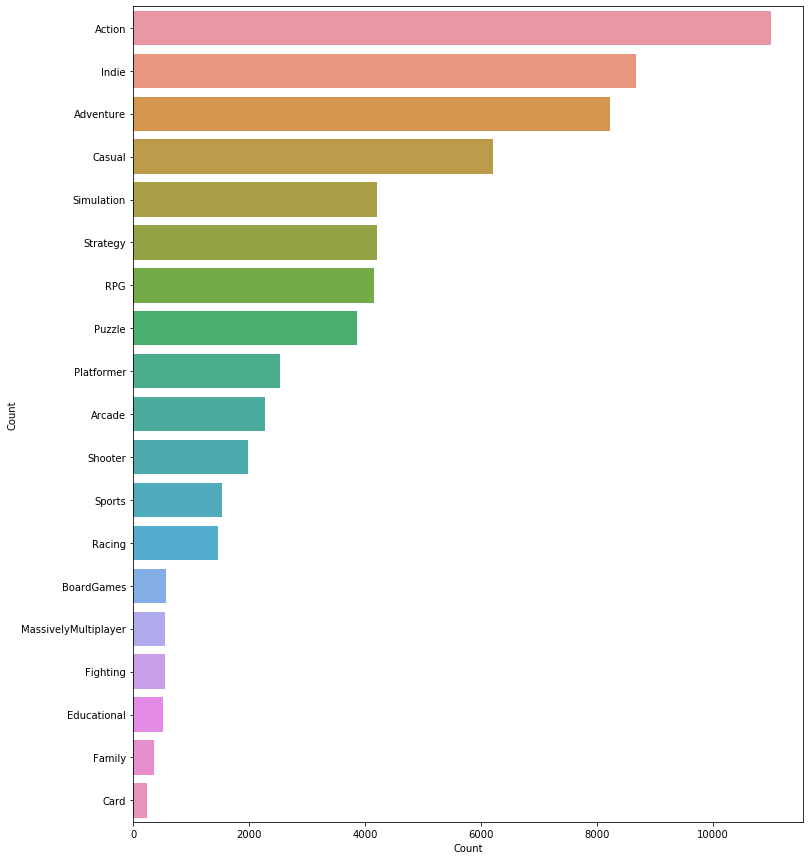

In [8]:
g = all_genres_df.nlargest(columns="Count", n = 50) 
plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=g, x= "Count", y = "Genre") 
ax.set(ylabel = 'Count') 
plt.show()

In [9]:
multilabel_binarizer = MultiLabelBinarizer()
multilabel_binarizer.fit(games_new['genre_new'])

# transform target variable
y = multilabel_binarizer.transform(games_new['genre_new'])

In [73]:

f = pd.DataFrame(games_new)
i=0
for genre in list(all_genres.keys()):
    genreli = y[:,i]
    f[genre] = genreli 
    i=i+1
    
print(f)


           id                                                 name  \
0       28310                                0 day attack on earth   
1       10235                                                0 day   
2      386925                                      0 hour meltdown   
3      381643                                         0 lives left   
4      379914                           0 robert blaster391 arnold   
...       ...                                                  ...   
32526   46330  ne no kami the two princess knights of kyoto part 2   
32527   13631         ne no kami the two princess knights of kyoto   
32528  365570                                                 ne10   
32529  377246                                                ne3no   
32530   28165                                near death experience   

                                                                                                                                                               

In [58]:
print(y)

[[0 0 0 ... 0 0 0]
 [1 1 0 ... 0 0 1]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [30]:
# split dataset into training and validation set
xtrain, xval, ytrain, yval = train_test_split(games_new['description'], y, test_size=0.2, random_state=9)

In [27]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=10000)

In [28]:
print(xtrain[1])

freedom movement flight touch pad teleportation move city hunting enemies growing assortment weapons homemade spears assault rifles sneak armed targets catch guard maneuver full speed around bullets bat head distance take back control city terrorist infected help shape game give feedback work make game want encourage read early access plans purchasing development continues scenarios features content added including indepth rts mode active cities customer feedback gets taken account decision making promise heard


In [36]:
xtrain_tfidf = tfidf_vectorizer.fit_transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)
print(xtrain_tfidf[1])

  (0, 1982)	0.07187131004022689
  (0, 3448)	0.06677940281978832
  (0, 7859)	0.1629901709787876
  (0, 7719)	0.09388313153657911
  (0, 226)	0.10117704111514818
  (0, 4372)	0.08546773068003266
  (0, 9172)	0.20635406910158047
  (0, 9173)	0.06760503851691882
  (0, 7282)	0.20756322814996403
  (0, 5316)	0.1387888011854875
  (0, 6038)	0.222562565136312
  (0, 5379)	0.21338327981683436
  (0, 5043)	0.25759748169809393
  (0, 8884)	0.34346330893079197
  (0, 57)	0.05402946218189156
  (0, 90)	0.07124856548376
  (0, 8792)	0.052602741924034024
  (0, 9647)	0.07077239241067924
  (0, 3060)	0.0814950854893938
  (0, 3402)	0.061786893533423204
  (0, 6178)	0.029397497564472193
  (0, 9955)	0.0969903820547059
  (0, 200)	0.062154398058011116
  (0, 9497)	0.054296958225851906
  (0, 7909)	0.0676953055281497
  :	:
  (0, 3394)	0.08672096043135787
  (0, 6013)	0.02895534200368714
  (0, 113)	0.05690138449377199
  (0, 9108)	0.0610836629454412
  (0, 252)	0.2415763656828083
  (0, 2272)	0.23148027389472145
  (0, 45)	0.07239

In [34]:
# get the first vector out (for the first document)
first_vector_tfidfvectorizer=xtrain_tfidf[1]

# place tf-idf values in a pandas data frame
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head(20)


,tfidf
tecmo,0.343463
koei,0.257597
alive,0.241576
dead,0.231480
ninja,0.222563
ltd,0.213383
registered,0.207563
trademark,0.206354
sega,0.162990
logo,0.138789


In [16]:
print(xtrain_tfidf)

  (0, 1460)	0.1228904009754436
  (0, 8226)	0.08492038796554967
  (0, 6912)	0.10076585431092122
  (0, 8556)	0.12959746905465275
  (0, 5367)	0.10471752428296348
  (0, 2606)	0.09580162460977816
  (0, 5324)	0.06383329547235908
  (0, 5060)	0.1142058570347763
  (0, 1493)	0.15002665469226906
  (0, 3812)	0.08956480716004132
  (0, 5447)	0.04556461024831238
  (0, 7914)	0.05717063457478924
  (0, 8865)	0.06010668943869334
  (0, 5847)	0.12738863746067658
  (0, 9776)	0.11873324183632006
  (0, 4265)	0.10274004842150534
  (0, 4854)	0.06361303036394148
  (0, 8301)	0.09740887480881605
  (0, 6380)	0.06763012376166493
  (0, 2750)	0.10757663222969877
  (0, 2847)	0.08935181933999761
  (0, 3597)	0.07995468913476168
  (0, 5161)	0.2490918960831365
  (0, 6191)	0.09241965769321439
  (0, 7437)	0.11783887996235909
  :	:
  (26023, 8297)	0.09927098512733701
  (26023, 4405)	0.12113522552973433
  (26023, 3166)	0.16726312552259123
  (26023, 757)	0.15111324808440818
  (26023, 6814)	0.4016761170856961
  (26023, 2069)	0.1

In [ ]:
LogReg_pipeline = Pipeline([
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=-1)),
            ])
for category in categories:
    print('**Processing {} comments...**'.format(category))
    
    # Training logistic regression model on train data
    LogReg_pipeline.fit(x_train, train[category])
    
    # calculating test accuracy
    prediction = LogReg_pipeline.predict(x_test)
    print('Test accuracy is {}'.format(accuracy_score(test[category], prediction)))
    print("\n")

In [17]:
lr = LogisticRegression()
clf = OneVsRestClassifier(lr)

In [18]:
# fit model on train data
clf.fit(xtrain_tfidf, ytrain)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='auto',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='lbfgs', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)

In [19]:
# make predictions for validation set
y_pred = clf.predict(xval_tfidf)

In [42]:
from sklearn.metrics import accuracy_score
accuracy_score(yval, y_pred)

0.2094667281389273

In [ ]:
# using binary relevance
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB

# initialize binary relevance multi-label classifier
# with a gaussian naive bayes base classifier
classifier = BinaryRelevance(GaussianNB())

# train
classifier.fit(x_train, y_train)

# predict
predictions = classifier.predict(x_test)

# accuracy
print("Accuracy = ",accuracy_score(y_test,predictions))
print("\n")

In [20]:
y_pred[3]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0])

In [21]:
multilabel_binarizer.inverse_transform(y_pred)[3]

('Platformer',)

In [22]:
f1_score(yval, y_pred, average="micro")

0.5353973168214655

In [44]:
# predict probabilities
y_pred_prob = clf.predict_proba(xval_tfidf)

In [52]:
t = 0.3 # threshold value
y_pred_new = (y_pred_prob >= t).astype(int)

In [50]:
# evaluate performance
f1_score(yval, y_pred_new, average="micro")





0.5353973168214655

In [51]:
from sklearn.metrics import accuracy_score
accuracy_score(yval, y_pred)

0.2094667281389273